<a id="top"></a>
## **Reciept Multimodal AI Demonstration**

**Description:** Attached is a demo that leverages Azure Document Intelligence and advanced generative AI models, including GPT-4o, to automatically extract structured data from receipt images, categorize spending, and visualize expense breakdowns across receipts. It's intended to demonstrate multimodal AI's capabilities and provide documentation for effective ways of achieve such results.

**Important:** This is the step by step process I used to get to my active working version of my receipt analyzer

**Sections**
1. [Intro & Setup](#setup)
2. [Basic Prompting](#basic)
    - Begin by using a GPT model to read and extract data from the reciept
    - GPT model is not specialized in this field and has issues interpreting values

3. [Modified Prompting and Model](#modified)
    - Switch to a Document Intelligence Model to interpret and extract data from the receipt
    - Pass data to GPT model to sort the information
    - Manually Graph the information outputted from the GPT model

4. [Final Optimization](#optimized)
    - Optmized process so GPT model automatically calls function to directly graph data
    - User now only has to pass inital receipt to recieve all their desired information

<a id="setup"></a>

### **1. Setup**

[Back to Table of Contents](#top)

In [1]:
%%capture
%pip install openai
%pip install python-dotenv
%pip install matplotlib
%pip install pillow
%pip install azure-ai-documentintelligence

In [2]:
# Importing the necessary Python libraries
from openai import AzureOpenAI
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import json
import re
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential

In [3]:
# Loading the environment variables
#load_dotenv()

# Instantiating the OpenAI client
openai_client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://aisdevelopment.openai.azure.com/",
    api_key="DTyQG79lV7tPjYYFAB9sGzYe8MkQSrdLsosDYlUEIqAjNQ9NDtZZJQQJ99BFACYeBjFXJ3w3AAABACOGBm6d"
)

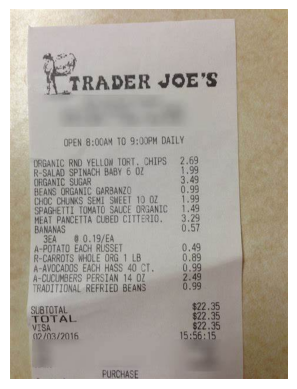

In [4]:
# Load the image
input_file_name = 'input/reciept2.jpg'
img = mpimg.imread(input_file_name)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
# Loading the image from file as a base64 encoding
with open(input_file_name, 'rb') as image_file:
    b64_img = base64.b64encode(image_file.read()).decode('utf-8')

<a id="basic"></a>

### **2. Basic Prompting**

[Back to Table of Contents](#top)

Notice how the outputs dont match the actual reciept individual and total values

In [6]:
# Making a call using the new GPT-4 Turbo Vision
openai_response_image = openai_client.chat.completions.create(
  model = "gpt-4o",
  messages = [
      {
          'role': 'user',
          'content': [
              {
                  'type': 'text',
                  'text': """Analyze the image and:
                1. Retrieve the total of each item and sum those individual totals up to get a total amount. Dont just give me the total value listed on the reciept."""
              },
              {
                  'type': 'image_url',
                  'image_url': {
                      'url': f'data:image/jpeg;base64,{b64_img}'
                  }
              }
          ]
      }
  ],
  max_tokens = 1000
)
completion_response = openai_response_image.choices[0].message.content
print(completion_response)

Here's the breakdown of the items and their totals based on the receipt:

1. **Organic Rnd Yellow Tortilla Chips**: $2.69  
2. **R-Salad Spinach Baby 6 oz**: $1.99  
3. **Organic Sugar**: $3.99  
4. **Beans Organic Garbanzo**: $0.99  
5. **Choc Chunks Semi Sweet 10 oz**: $1.99  
6. **Spaghetti Tomato Sauce Organic**: $1.49  
7. **Meat Pancetta Cubed Citterio**: $3.57  
8. **Bananas**:  
   - 3 bananas at $0.19 each = $0.57  
9. **Potato Each Russet**: $0.49  
10. **R-Carrots Whole Org 1 lb**: $0.89  
11. **Avocados Each Hass 40 ct**: $0.99  
12. **A-Cucumbers Persian 14 oz**: $2.99  
13. **Traditional Refried Beans**: $0.79  

### Calculating the total:
- $2.69 + $1.99 + $3.99 + $0.99 + $1.99 + $1.49 + $3.57 + $0.57 + $0.49 + $0.89 + $0.99 + $2.99 + $0.79 = **$22.43**

The total calculated value is **$22.43**, which slightly differs from the subtotal provided on the receipt ($22.35). This discrepancy might be due to rounding or hidden discounts applied by the store.


<a id="modified"></a>

### **3. Modified Prompting and Model**

[Back to Table of Contents](#top)

Notice how the AI now correctly finds and lists every item on the reciept

In [7]:
document_intelligence_client = DocumentIntelligenceClient(
    endpoint="https://testreadreciept.cognitiveservices.azure.com/",
    credential=AzureKeyCredential("39iwdH3cbVrTiGFLksknxzvPZDP2qBD6E5QQ97HgsyKg19ou4odPJQQJ99BFACYeBjFXJ3w3AAALACOGgR2Z")
)
with open(input_file_name, 'rb') as image_file:
    #use the reciept model
    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-receipt", 
        image_file,
        content_type="application/octet-stream"
    )
result = poller.result()

#display results
print("Receipt Analysis Results:")
finalCost = 0
extracted_items = []

if result.documents:
    for document in result.documents:       
        items = document.fields["Items"].value_array

        for i, item in enumerate(items):
            #get price
            item_value = item.value_object
            if item_value.get("TotalPrice"):
                item_total = item_value.get("TotalPrice").content
            else:
                item_total = "N/A"
            
            if item_total != "N/A":
                finalCost += float(item_total)


            #get item name
            possible_name_keys = ["Name", "Description", "Item", "Product", "Title"]
            item_name = None
            for key in possible_name_keys:
                field = item_value.get(key)
                if field and getattr(field, "content", "").strip():
                    item_name = field.content.strip()
                    break
            if not item_name:
                item_name = "Unnamed Item"

            if item_total != "N/A":
                extracted_items.append({"name": item_name, "price": float(item_total)})

            print(item_name + " || total: $" + item_total)
            #print(extracted_items)
        
print(f"Subtotal: ${finalCost}")

Receipt Analysis Results:
ORGANIC RND YELLOW TORT. CHIPS || total: $2.69
R-SALAD SPINACH BABY 6 OZ || total: $1.99
ORGANIC SUGAR || total: $3.49
BEANS ORGANIC GARBANZO || total: $0.99
CHOC CHUNKS SEMI SWEET 10 OZ || total: $1.99
SPAGHETTI TOMATO SAUCE ORGANIC || total: $1.49
MEAT PANCETTA CUBED CITTERIO. || total: $3.29
BANANAS || total: $0.57
A-POTATO EACH RUSSET || total: $0.49
R-CARROTS WHOLE ORG 1 LB || total: $0.89
A-AVOCADOS EACH HASS 40 CT. || total: $0.99
A-CUCUMBERS PERSIAN 14 OZ || total: $2.49
TRADITIONAL REFRIED BEANS || total: $0.99
Subtotal: $22.349999999999998


**Now that we have the reciepts read and outputted I will be taking the reciepts and using a second GPT model to categorize each item into seperate categories to track how spending is distributed.**

In [8]:
response = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "You're a helpful assistant that categorizes spending from receipts into meaningful budget categories."
        },
        {
            "role": "user", 
            "content": f"""Here is a list of items from a receipt:
                {extracted_items}
                Please do the following:
                1. Categorize each item into a category like Food, Health, Leisure, Household, or Other.
                2. provide further seperation into each category by dividing items into subcategories like Groceries-produce, groceries-meat, restaurant-fast food, restaurant-dine in, etc.
                3. Group totals by category and find the total spending in each category by manually adding each item in that category.
                4. Acquire the total spending across all categories by adding up the totals of each category.
                5. Your output should resemble the following guidelines:

### **1. Categorization & Subcategorization**  

#### **Category: Food**
**Subcategory: Groceries - Produce**
- BANANAS ($0.57)
- A-POTATO EACH RUSSET ($0.49)
- R-CARROTS WHOLE ORG 1 LB ($0.89)
- A-AVOCADOS EACH HASS 40 CT ($0.99)
- A-CUCUMBERS PERSIAN 14 OZ ($2.49)

**Subcategory: Groceries - Pantry Staples**
- ORGANIC RND YELLOW TORT. CHIPS ($2.69)
- ORGANIC SUGAR ($3.49)
- BEANS ORGANIC GARBANZO ($0.99)
- CHOC CHUNKS SEMI SWEET 10 OZ ($1.99)
- SPAGHETTI TOMATO SAUCE ORGANIC ($1.49)
- TRADITIONAL REFRIED BEANS ($0.99)

**Subcategory: Groceries - Meat**
- MEAT PANCETTA CUBED CITTERIO ($3.29)

**Subcategory: Groceries - Salads**
- R-SALAD SPINACH BABY 6 OZ ($1.99)

---

### **3. Totals by Category**

**Overall Food Total**: $5.43 + $11.64 + $3.29 + $1.99 = **$22.35**
#### **Food**
- This receipt represents spending primarily on groceries for home cooking and eating. Produce items such as bananas, potatoes, carrots, avocados, and cucumbers were purchased for everyday cooking or snacking ($5.43). Pantry staples include essentials like tortilla chips, sugar, garbanzo beans, semi-sweet chocolate chunks, tomato sauce, and refried beans ($11.64). A specific meat item, pancetta cubes, was purchased ($3.29), along with baby spinach salad for fresh greens ($1.99).  
**Total Food Spending**: **$22.35**

#### **Overall Total Spending**: **$22.35**

If you can, also return the totals by category as a **JSON object** at the end, like:
```json
{{
  "Food-grocery-produce": 22.35,
   "Food-dineout": 22.35,
   "Food-grocery-meat": 22.35,
  "Health": 5.20,
  "Leisure": 0,
  "Household": 7.85,
  "Other": 0
   "Overall Total Spending": 22.35
}}"""
        }
    ]
)

print(response.choices[0].message.content)

### **1. Categorization & Subcategorization**  

#### **Category: Food**
**Subcategory: Groceries - Produce**
- BANANAS ($0.57)
- A-POTATO EACH RUSSET ($0.49)
- R-CARROTS WHOLE ORG 1 LB ($0.89)
- A-AVOCADOS EACH HASS 40 CT. ($0.99)
- A-CUCUMBERS PERSIAN 14 OZ ($2.49)

**Subcategory: Groceries - Pantry Staples**
- ORGANIC RND YELLOW TORT. CHIPS ($2.69)
- ORGANIC SUGAR ($3.49)
- BEANS ORGANIC GARBANZO ($0.99)
- CHOC CHUNKS SEMI SWEET 10 OZ ($1.99)
- SPAGHETTI TOMATO SAUCE ORGANIC ($1.49)
- TRADITIONAL REFRIED BEANS ($0.99)

**Subcategory: Groceries - Meat**
- MEAT PANCETTA CUBED CITTERIO. ($3.29)

**Subcategory: Groceries - Salads**
- R-SALAD SPINACH BABY 6 OZ ($1.99)

---

### **3. Totals by Category**

#### **Food**
**Subcategory Total: Groceries - Produce**
- BANANAS ($0.57) + A-POTATO EACH RUSSET ($0.49) + R-CARROTS WHOLE ORG 1 LB ($0.89) + A-AVOCADOS EACH HASS 40 CT. ($0.99) + A-CUCUMBERS PERSIAN 14 OZ ($2.49) = **$5.43**

**Subcategory Total: Groceries - Pantry Staples**
- ORGANIC 

**Since we have this outputted data we can copy over the json data and graph it. Note: this is not scalable and effective for larger datasets**

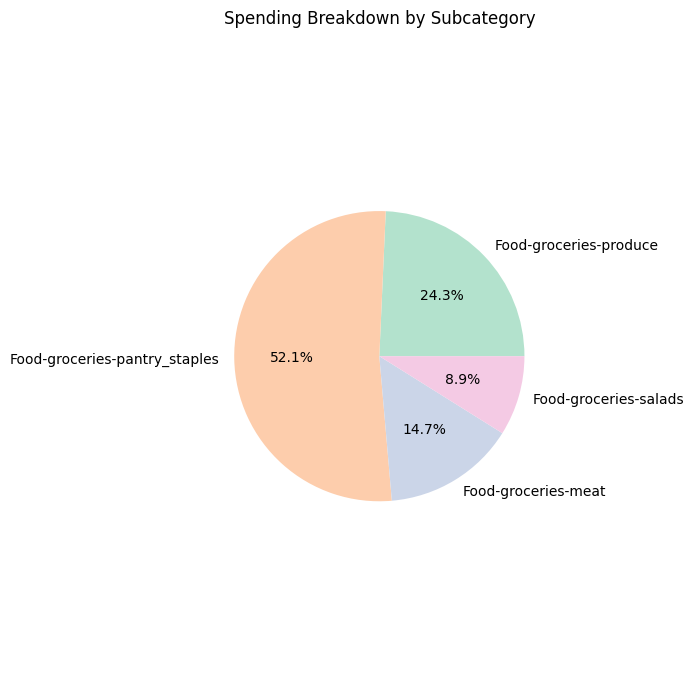

In [9]:
json_data = '''
{
  "Food-groceries-produce": 5.43,
  "Food-groceries-pantry_staples": 11.64,
  "Food-groceries-meat": 3.29,
  "Food-groceries-salads": 1.99
}
'''

category_totals = json.loads(json_data)
def plot_pie_chart(data):
    labels = list(data.keys())
    values = list(data.values())

    plt.figure(figsize=(7, 7))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=plt.cm.Pastel2.colors)
    plt.title('Spending Breakdown by Subcategory')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_pie_chart(category_totals)

<a id="optimized"></a>

### **4. Final Optimization**

[Back to Table of Contents](#top)

We can have the GPT model use function calling to directly division items and produce the pie graph

### Categorization of Receipt Items:
1. **ORGANIC RND YELLOW TORT. CHIPS**: Food → Snacks
2. **R-SALAD SPINACH BABY 6 OZ**: Food → Groceries → Produce
3. **ORGANIC SUGAR**: Food → Groceries → Pantry
4. **BEANS ORGANIC GARBANZO**: Food → Groceries → Pantry
5. **CHOC CHUNKS SEMI SWEET 10 OZ**: Food → Groceries → Pantry
6. **SPAGHETTI TOMATO SAUCE ORGANIC**: Food → Groceries → Pantry
7. **MEAT PANCETTA CUBED CITTERIO.**: Food → Groceries → Meat
8. **BANANAS**: Food → Groceries → Produce
9. **A-POTATO EACH RUSSET**: Food → Groceries → Produce
10. **R-CARROTS WHOLE ORG 1 LB**: Food → Groceries → Produce
11. **A-AVOCADOS EACH HASS 40 CT.**: Food → Groceries → Produce
12. **A-CUCUMBERS PERSIAN 14 OZ**: Food → Groceries → Produce
13. **TRADITIONAL REFRIED BEANS**: Food → Groceries → Pantry

### Group Totals by Category:
1. **Food:**
   - **Snacks**: $2.69
   - **Groceries (Produce)**: $1.99 + $0.57 + $0.49 + $0.89 + $0.99 + $2.49 = $7.42
   - **Groceries (Pantry)**: $3.49 + $0.99 + $1.99 + $1.

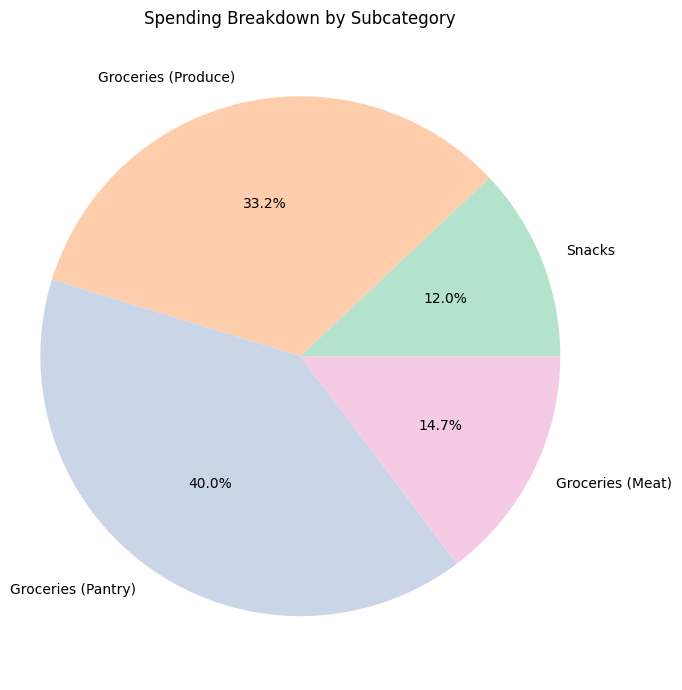

In [10]:
def plot_pie_chart(data):
    labels = list(data.keys())
    values = list(data.values())

    plt.figure(figsize=(7, 7))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=plt.cm.Pastel2.colors)
    plt.title('Spending Breakdown by Subcategory')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

functions = [
    {
        "name": "plot_pie_chart",
        "description": "Plots a pie chart based on categorized spending data",
        "parameters": {
            "type": "object",
            "properties": {},
            "additionalProperties": {
                "type": "number"
            }
        }
    }
]


response = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "You're a helpful assistant that categorizes spending from receipts into budget categories and generates graphs."
        },
        {
            "role": "user",
            "content": f"""Here is a list of items from a receipt:
                {extracted_items}

                Please:
                1. Categorize each item into a category like Food, Health, Leisure, Household, or Other.
                2. Provide further seperation into each category by dividing items into subcategories like Groceries-produce, groceries-meat, restaurant-fast food, restaurant-dine in, etc.
                3. Group totals by category and find the total spending in each category by manually adding each item in that category.
                4. Acquire the total spending across all categories by adding up the totals of each category.
                5. Return JSON with totals per category only.

                Call `plot_pie_chart(data)` using the spending totals JSON. If you only have one catergory of items, provide the pie chart with the subcategories, if you have multiple categories, provide the pie chart with the categories.

                Here is an example successful output: Let's start by categorizing each item:

                ### Categorization of Receipt Items:
                1. ORGANIC RND YELLOW TORT. CHIPS: Food → Snacks
                2. R-SALAD SPINACH BABY 6 OZ: Food → Groceries → Produce
                3. ORGANIC SUGAR: Food → Groceries → Pantry
                4. BEANS ORGANIC GARBANZO: Food → Groceries → Pantry
                5. CHOC CHUNKS SEMI SWEET 10 OZ: Food → Groceries → Pantry
                6. SPAGHETTI TOMATO SAUCE ORGANIC: Food → Groceries → Pantry
                7. MEAT PANCETTA CUBED CITTERIO.: Food → Groceries → Meat
                8. BANANAS: Food → Groceries → Produce
                9. A-POTATO EACH RUSSET: Food → Groceries → Produce
                10. R-CARROTS WHOLE ORG 1 LB: Food → Groceries → Produce
                11. A-AVOCADOS EACH HASS 40 CT.: Food → Groceries → Produce
                12. A-CUCUMBERS PERSIAN 14 OZ: Food → Groceries → Produce
                13. TRADITIONAL REFRIED BEANS: Food → Groceries → Pantry

                ### Group Totals by Category:
                1. **Food:**
                - Snacks: $2.69
                - Groceries (Produce): $1.99 + $0.57 + $0.49 + $0.89 + $0.99 + $2.49 = $7.42
                - Groceries (Pantry): $3.49 + $0.99 + $1.99 + $1.49 + $0.99 = $8.95
                - Groceries (Meat): $3.29
                - **Total for Food**: $2.69 + $7.42 + $8.95 + $3.29 = $22.35

                ### Total Spending Across All Categories:
                - **Total Spending**: $22.35 (since everything falls under Food).

                ### JSON Output with Spending Totals:
                

                Since there is only one category (Food), the pie chart will focus on the subcategories. I will proceed with plotting a pie chart.
                """
        }
    ],
    functions=functions,
    function_call="auto"
)

print(response.choices[0].message.content)
message = response.choices[0].message

# Check if GPT called the function
if message.function_call:
    arguments = json.loads(message.function_call.arguments)
    image_path = plot_pie_chart(arguments)
else:
    # In case GPT didn't use the function call
    print(message.content)

## Full Efficient Demonstration
We will be using the optimized code to run a demo of this system working on different reciepts

**Reciept #2**

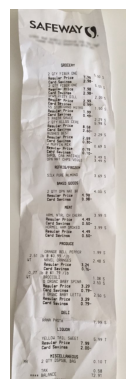

In [11]:
# Load the image
input_file_name = 'input/reciept1.jpeg'
img = mpimg.imread(input_file_name)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
document_intelligence_client = DocumentIntelligenceClient(
    endpoint="https://testreadreciept.cognitiveservices.azure.com/",
    credential=AzureKeyCredential("39iwdH3cbVrTiGFLksknxzvPZDP2qBD6E5QQ97HgsyKg19ou4odPJQQJ99BFACYeBjFXJ3w3AAALACOGgR2Z")
)
with open(input_file_name, 'rb') as image_file:
    #use the reciept model
    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-receipt", 
        image_file,
        content_type="application/octet-stream"
    )
result = poller.result()

#display results
print("Receipt Analysis Results:")
finalCost = 0
extracted_items = []

if result.documents:
    for document in result.documents:       
        items = document.fields["Items"].value_array

        for i, item in enumerate(items):
            #get price
            item_value = item.value_object
            if item_value.get("TotalPrice"):
                item_total = item_value.get("TotalPrice").content
            else:
                item_total = "N/A"
            
            if item_total != "N/A":
                finalCost += float(item_total)


            #get item name
            possible_name_keys = ["Name", "Description", "Item", "Product", "Title"]
            item_name = None
            for key in possible_name_keys:
                field = item_value.get(key)
                if field and getattr(field, "content", "").strip():
                    item_name = field.content.strip()
                    break
            if not item_name:
                item_name = "N/A"

            if item_total != "N/A":
                extracted_items.append({"name": item_name, "price": float(item_total)})

            print(item_name + " || total: $" + item_total)
            #print(extracted_items)
        
print(f"Subtotal: ${finalCost}")

Receipt Analysis Results:
2 QTY FIBER ONE || total: $5.00
2 QTY FIBER ONE || total: $5.00
SFWY ZESTY DILL || total: $2.00
SS STONEGRND MSTRD || total: $1.50
S PASTA SAUCE || total: $2.29
2 QTY KLLGS CERE || total: $5.98
BUSHES BEST || total: $2.29
J MUFFIN MIX || total: $0.69
GHRDL CAB MATINEE || total: $3.49
OPN NAT CHPS VEGGI || total: $3.49
SILK PURE ALMOND || total: $3.69
2 QTY OPN NAT BR || total: $4.00
HRML NTRL CH CHERR || total: $3.99
HORMEL HAM SMOKED || total: $3.99
ORANGE BELL PEPPER || total: $1.99
NAVEL ORANGES || total: $2.48
BROCCOLI || total: $1.38
O ORGNC BABY SPINA. || total: $2.50
O ORGNC BABY LETTU. || total: $2.50
RANA PASTA || total: $7.99
YELLOW TAIL SWEET || total: $5.99
2 QTY DSPSBL BAG || total: $0.10
Subtotal: $72.33


### Categorization of Receipt Items:

1. **FF BS BREAST**: Food → Groceries → Meat  
2. **KS DICED TOM**: Food → Groceries → Produce  
3. **JACKORGSALSA**: Food → Groceries → Pantry  
4. **18CT EGGS**: Food → Groceries → Dairy  
5. **GRAPE TOMATO**: Food → Groceries → Produce  
6. **ECO HALF PAN**: Household → Kitchen Essentials  
7. **GRND TURKEY**: Food → Groceries → Meat  
8. **CHPD ONION**: Food → Groceries → Produce  
9. **MONT JACK 2#**: Food → Groceries → Dairy  

---

### Group Totals by Category:

1. **Food:**
   - **Groceries → Meat**: $23.99 + $18.47 = $42.46  
   - **Groceries → Produce**: $6.49 + $6.29 + $3.59 = $16.37  
   - **Groceries → Pantry**: $2.97  
   - **Groceries → Dairy**: $12.87 + $4.45 = $17.32  
   - **Total for Food**: $42.46 + $16.37 + $2.97 + $17.32 = $79.12  

2. **Household:**
   - **Kitchen Essentials**: $6.49  
   - **Total for Household**: $6.49  

---

### Total Spending Across All Categories:
- **Total Spending**: $79.12 (Food) + $6.49 (Household) 

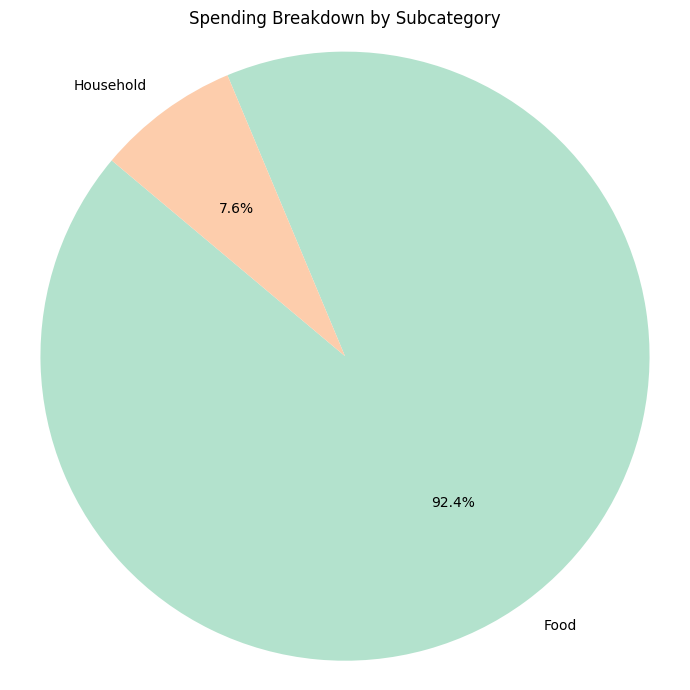

In [ ]:
def plot_pie_chart(data):
    labels = list(data.keys())
    values = list(data.values())

    plt.figure(figsize=(7, 7))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=plt.cm.Pastel2.colors)
    plt.title('Spending Breakdown by Subcategory')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

functions = [
    {
        "name": "plot_pie_chart",
        "description": "Plots a pie chart based on categorized spending data",
        "parameters": {
            "type": "object",
            "properties": {},
            "additionalProperties": {
                "type": "number"
            }
        }
    }
]


response = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "You're a helpful assistant that categorizes spending from receipts into budget categories and generates graphs."
        },
        {
            "role": "user",
            "content": f"""Here is a list of items from a receipt:
                {extracted_items}

                Please:
                1. Categorize each item into a category like Food, Health, Leisure, Household, or Other.
                2. Provide further seperation into each category by dividing items into subcategories like Groceries-produce, groceries-meat, restaurant-fast food, restaurant-dine in, etc.
                3. Group totals by category and find the total spending in each category by manually adding each item in that category.
                4. Acquire the total spending across all categories by adding up the totals of each category.
                5. Return JSON with totals per category only.

                Call `plot_pie_chart(data)` using the spending totals JSON. If you only have one catergory of items, provide the pie chart with the subcategories, if you have multiple categories, provide the pie chart with the categories.

                Here is an example successful output: Let's start by categorizing each item:

                ### Categorization of Receipt Items:
                1. ORGANIC RND YELLOW TORT. CHIPS: Food → Snacks
                2. R-SALAD SPINACH BABY 6 OZ: Food → Groceries → Produce
                3. ORGANIC SUGAR: Food → Groceries → Pantry
                4. BEANS ORGANIC GARBANZO: Food → Groceries → Pantry
                5. CHOC CHUNKS SEMI SWEET 10 OZ: Food → Groceries → Pantry
                6. SPAGHETTI TOMATO SAUCE ORGANIC: Food → Groceries → Pantry
                7. MEAT PANCETTA CUBED CITTERIO.: Food → Groceries → Meat
                8. BANANAS: Food → Groceries → Produce
                9. A-POTATO EACH RUSSET: Food → Groceries → Produce
                10. R-CARROTS WHOLE ORG 1 LB: Food → Groceries → Produce
                11. A-AVOCADOS EACH HASS 40 CT.: Food → Groceries → Produce
                12. A-CUCUMBERS PERSIAN 14 OZ: Food → Groceries → Produce
                13. TRADITIONAL REFRIED BEANS: Food → Groceries → Pantry

                ### Group Totals by Category:
                1. **Food:**
                - Snacks: $2.69
                - Groceries (Produce): $1.99 + $0.57 + $0.49 + $0.89 + $0.99 + $2.49 = $7.42
                - Groceries (Pantry): $3.49 + $0.99 + $1.99 + $1.49 + $0.99 = $8.95
                - Groceries (Meat): $3.29
                - **Total for Food**: $2.69 + $7.42 + $8.95 + $3.29 = $22.35

                ### Total Spending Across All Categories:
                - **Total Spending**: $22.35 (since everything falls under Food).

                ### JSON Output with Spending Totals:
                

                Since there is only one category (Food), the pie chart will focus on the subcategories. I will proceed with plotting a pie chart.
                """
        }
    ],
    functions=functions,
    function_call="auto"
)

print(response.choices[0].message.content)
message = response.choices[0].message

# Check if GPT called the function
if message.function_call:
    arguments = json.loads(message.function_call.arguments)
    image_path = plot_pie_chart(arguments)
else:
    # In case GPT didn't use the function call
    print(message.content)

**Reciept #3 Demo**

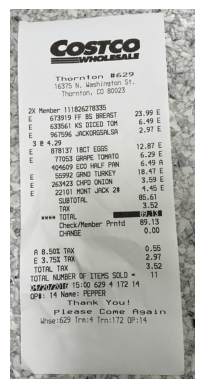

In [14]:
# Load the image
input_file_name = 'input/reciept3.png'
img = mpimg.imread(input_file_name)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
document_intelligence_client = DocumentIntelligenceClient(
    endpoint="https://testreadreciept.cognitiveservices.azure.com/",
    credential=AzureKeyCredential("39iwdH3cbVrTiGFLksknxzvPZDP2qBD6E5QQ97HgsyKg19ou4odPJQQJ99BFACYeBjFXJ3w3AAALACOGgR2Z")
)
with open(input_file_name, 'rb') as image_file:
    #use the reciept model
    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-receipt", 
        image_file,
        content_type="application/octet-stream"
    )
result = poller.result()

#display results
print("Receipt Analysis Results:")
finalCost = 0
extracted_items = []

if result.documents:
    for document in result.documents:       
        items = document.fields["Items"].value_array

        for i, item in enumerate(items):
            #get price
            item_value = item.value_object
            if item_value.get("TotalPrice"):
                item_total = item_value.get("TotalPrice").content
            else:
                item_total = "N/A"
            
            if item_total != "N/A":
                finalCost += float(item_total)


            #get item name
            possible_name_keys = ["Name", "Description", "Item", "Product", "Title"]
            item_name = None
            for key in possible_name_keys:
                field = item_value.get(key)
                if field and getattr(field, "content", "").strip():
                    item_name = field.content.strip()
                    break
            if not item_name:
                item_name = "Unnamed Item"

            if item_total != "N/A":
                extracted_items.append({"name": item_name, "price": float(item_total)})

            print(item_name + " || total: $" + item_total)
            #print(extracted_items)
        
print(f"Subtotal: ${finalCost}")

Receipt Analysis Results:
FF BS BREAST || total: $23.99
KS DICED TOM || total: $6.49
JACKORGSALSA || total: $2.97
18CT EGGS || total: $12.87
GRAPE TOMATO || total: $6.29
ECO HALF PAN || total: $6.49
GRND TURKEY || total: $18.47
CHPD ONION || total: $3.59
MONT JACK 2# || total: $4.45
Subtotal: $85.61


### Categorization of Receipt Items:
1. **FF BS BREAST:** Food → Groceries → Meat ($23.99)
2. **KS DICED TOM:** Food → Groceries → Produce ($6.49)
3. **JACKORGSALSA:** Food → Groceries → Pantry ($2.97)
4. **18CT EGGS:** Food → Groceries → Pantry ($12.87)
5. **GRAPE TOMATO:** Food → Groceries → Produce ($6.29)
6. **ECO HALF PAN:** Household → Kitchen Supplies ($6.49)
7. **GRND TURKEY:** Food → Groceries → Meat ($18.47)
8. **CHPD ONION:** Food → Groceries → Produce ($3.59)
9. **MONT JACK 2#:** Food → Groceries → Dairy ($4.45)

---

### Group Totals by Category:
**1. Food:**  
- **Groceries (Produce):** $6.49 + $6.29 + $3.59 = **$16.37**  
- **Groceries (Meat):** $23.99 + $18.47 = **$42.46**  
- **Groceries (Pantry):** $2.97 + $12.87 = **$15.84**  
- **Groceries (Dairy):** $4.45  
- **Total for Food:** $16.37 + $42.46 + $15.84 + $4.45 = **$79.12**

**2. Household:**  
- **Kitchen Supplies:** $6.49  
- **Total for Household:** $6.49

---

### Total Spending Across All Categories:
- **Food:

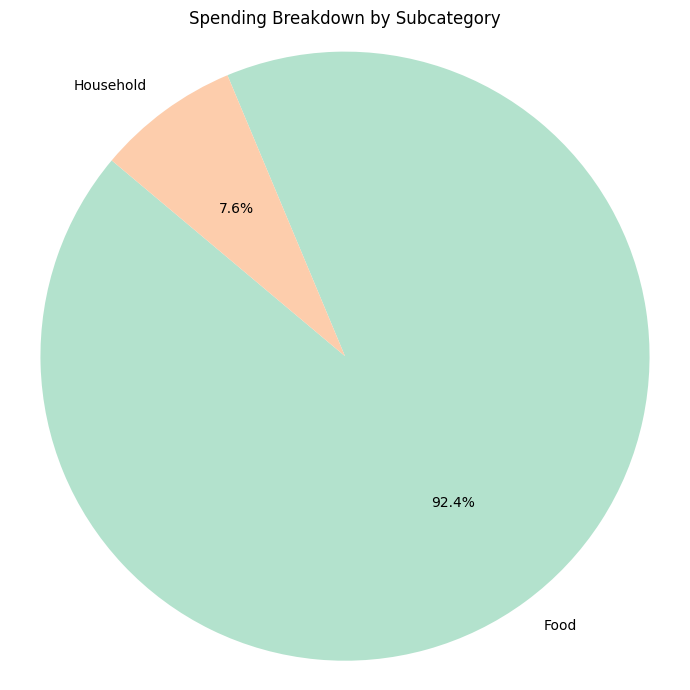

In [ ]:
def plot_pie_chart(data):
    labels = list(data.keys())
    values = list(data.values())

    plt.figure(figsize=(7, 7))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel2.colors)
    plt.title('Spending Breakdown by Subcategory')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

functions = [
    {
        "name": "plot_pie_chart",
        "description": "Plots a pie chart based on categorized spending data",
        "parameters": {
            "type": "object",
            "properties": {},
            "additionalProperties": {
                "type": "number"
            }
        }
    }
]


response = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "You're a helpful assistant that categorizes spending from receipts into budget categories and generates graphs."
        },
        {
            "role": "user",
            "content": f"""Here is a list of items from a receipt:
                {extracted_items}

                Please:
                1. Categorize each item into a category like Food, Health, Leisure, Household, or Other.
                2. Provide further seperation into each category by dividing items into subcategories like Groceries-produce, groceries-meat, restaurant-fast food, restaurant-dine in, etc.
                3. Group totals by category and find the total spending in each category by manually adding each item in that category.
                4. Acquire the total spending across all categories by adding up the totals of each category.
                5. Return JSON with totals per category only.

                Call `plot_pie_chart(data)` using the spending totals JSON. If you only have one catergory of items, provide the pie chart with the subcategories, if you have multiple categories, provide the pie chart with the categories.

                Here is an example successful output: Let's start by categorizing each item:

                ### Categorization of Receipt Items:
                1. ORGANIC RND YELLOW TORT. CHIPS: Food → Snacks
                2. R-SALAD SPINACH BABY 6 OZ: Food → Groceries → Produce
                3. ORGANIC SUGAR: Food → Groceries → Pantry
                4. BEANS ORGANIC GARBANZO: Food → Groceries → Pantry
                5. CHOC CHUNKS SEMI SWEET 10 OZ: Food → Groceries → Pantry
                6. SPAGHETTI TOMATO SAUCE ORGANIC: Food → Groceries → Pantry
                7. MEAT PANCETTA CUBED CITTERIO.: Food → Groceries → Meat
                8. BANANAS: Food → Groceries → Produce
                9. A-POTATO EACH RUSSET: Food → Groceries → Produce
                10. R-CARROTS WHOLE ORG 1 LB: Food → Groceries → Produce
                11. A-AVOCADOS EACH HASS 40 CT.: Food → Groceries → Produce
                12. A-CUCUMBERS PERSIAN 14 OZ: Food → Groceries → Produce
                13. TRADITIONAL REFRIED BEANS: Food → Groceries → Pantry

                ### Group Totals by Category:
                1. **Food:**
                - Snacks: $2.69
                - Groceries (Produce): $1.99 + $0.57 + $0.49 + $0.89 + $0.99 + $2.49 = $7.42
                - Groceries (Pantry): $3.49 + $0.99 + $1.99 + $1.49 + $0.99 = $8.95
                - Groceries (Meat): $3.29
                - **Total for Food**: $2.69 + $7.42 + $8.95 + $3.29 = $22.35

                ### Total Spending Across All Categories:
                - **Total Spending**: $22.35 (since everything falls under Food).

                ### JSON Output with Spending Totals:
                

                Since there is only one category (Food), the pie chart will focus on the subcategories. I will proceed with plotting a pie chart.
                """
        }
    ],
    functions=functions,
    function_call="auto"
)

print(response.choices[0].message.content)
message = response.choices[0].message

# Check if GPT called the function
if message.function_call:
    arguments = json.loads(message.function_call.arguments)
    image_path = plot_pie_chart(arguments)
else:
    # In case GPT didn't use the function call
    print(message.content)

[Back to Table of Contents](#top)